## Packages

### Two families: ProtBERT embeddings + PCA + t-SNE

In [9]:
import requests
import gzip
import io
from Bio import SeqIO
from Bio import AlignIO
import pandas as pd
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, difflib, numpy as np, torch, io, gzip
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np, torch

In [2]:
# -----------------------------
# Step 1: Download Pfam-A.seed.gz
# -----------------------------
url = "https://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam35.0/Pfam-A.seed.gz"
response = requests.get(url, stream=True)
response.raise_for_status()

pfam_ids = ["PF00069", "PF00072"]  # Protein kinase + GPCR example
records_by_family = {pfam: [] for pfam in pfam_ids}

In [3]:
# -----------------------------
# Step 2: Parse manually, track #=GF AC
# -----------------------------
current_acc = None
block_lines = []

def process_block(block_lines, current_acc):
    """Convert collected lines into an alignment and store if matches PFAM IDs"""
    if not block_lines or current_acc not in records_by_family:
        return
    # Add missing Stockholm header and footer
    block_text = "# STOCKHOLM 1.0\n" + "".join(block_lines) + "//\n"
    handle = io.StringIO(block_text)
    alignment = AlignIO.read(handle, "stockholm")
    records_by_family[current_acc].extend(alignment)

with gzip.open(io.BytesIO(response.content), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            # Process previous block
            process_block(block_lines, current_acc)
            block_lines = [line]
            current_acc = line.split()[2].split(".")[0]  # strip version
        elif line.strip() == "//":  # end of block
            block_lines.append(line)
            process_block(block_lines, current_acc)
            block_lines = []
            current_acc = None
        else:
            block_lines.append(line)

for pfam, seqs in records_by_family.items():
    print(f"{pfam}: {len(seqs)} sequences")


PF00069: 38 sequences
PF00072: 52 sequences


In [ ]:
# ====== Step 3: Clean sequences (remove alignment gaps) ======

def clean_seq(raw):
    """Remove Stockholm alignment gaps and keep amino-acid letters."""
    s = str(raw).replace("-", "").replace(".", "").replace("~", "")
    s = "".join([c for c in s if c.isalpha()]).upper()
    return s

# Collect and clean domain sequences from two families (deduplicate, length filter within ProtBERT-safe range)
min_len, max_len = 20, 1022  # BERT max length ~1024 (reserve [CLS]/[SEP])
seq_texts, seq_labels = [], []
per_family_counts = {}

for fam, recs in records_by_family.items():
    seen = set()
    kept = 0
    for rec in recs:
        s = clean_seq(rec.seq)
        if not s or len(s) < min_len or len(s) > max_len:
            continue
        if s in seen:
            continue
        seen.add(s)
        # ProtBERT expects space-separated amino-acid characters
        seq_texts.append(" ".join(list(s)))
        seq_labels.append(fam)
        kept += 1
    per_family_counts[fam] = kept

print("After cleaning & dedup:")
for fam, n in per_family_counts.items():
    print(f"  {fam}: {n} sequences kept")
assert len(seq_texts) > 5, "Too few samples; use Pfam full or select more families."

/Users/penglishao/anaconda3/envs/protBERT_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


After cleaning & dedup:
  PF00069: 38 sequences kept
  PF00072: 52 sequences kept


In [5]:
# ====== Step 4: ProtBERT embeddings (mean-pooling without special tokens) ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(name, do_lower_case=False)
model = AutoModel.from_pretrained(name).to(device).eval()

def batch(iterable, n=16):
    for i in range(0, len(iterable), n):
        yield i, iterable[i:i+n]

emb_list = []
bsz = 16 if device.type == "cuda" else 4
torch.set_grad_enabled(False)

for i, seq_batch in batch(seq_texts, bsz):
    enc = tokenizer(
        seq_batch,
        return_tensors="pt",
        padding=True,
        truncation=True,
        add_special_tokens=True,
    )
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc)  # last_hidden_state: [B, L, D]
        hidden = out.last_hidden_state       # [B, L, D]
        input_ids = enc["input_ids"]         # [B, L]
        attn = enc["attention_mask"]         # [B, L]

        # mask 掉 [CLS]/[SEP]
        cls_id, sep_id = tokenizer.cls_token_id, tokenizer.sep_token_id
        special_mask = (input_ids == cls_id) | (input_ids == sep_id)
        valid_mask = attn.bool() & (~special_mask)
        valid_mask = valid_mask.unsqueeze(-1)             # [B, L, 1]

        masked = hidden * valid_mask                      # [B, L, D]
        lengths = valid_mask.sum(dim=1).clamp(min=1)      # [B, 1]
        mean_vec = masked.sum(dim=1) / lengths            # [B, D]

        # L2 归一化，余弦空间更稳定
        mean_vec = torch.nn.functional.normalize(mean_vec, p=2, dim=-1)
        emb_list.append(mean_vec.cpu())

emb = torch.cat(emb_list, dim=0).numpy()   # [N, D]
labels = np.array(seq_labels)

Using device: cpu


/Users/penglishao/anaconda3/envs/protBERT_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:

# ====== Step 5: PCA -> t-SNE ======
# First reduce to 50 dims with PCA for denoising (auto-adjust for small samples)
n_samples, d = emb.shape
pca_dim = int(min(50, d, max(2, n_samples - 2)))
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(emb)

# Set t-SNE perplexity adaptively based on sample size
max_perplex = 30
perplex = max(5, min(max_perplex, (n_samples - 1) // 3))
tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perplex,
    random_state=42,
)
X_tsne = tsne.fit_transform(X_pca)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


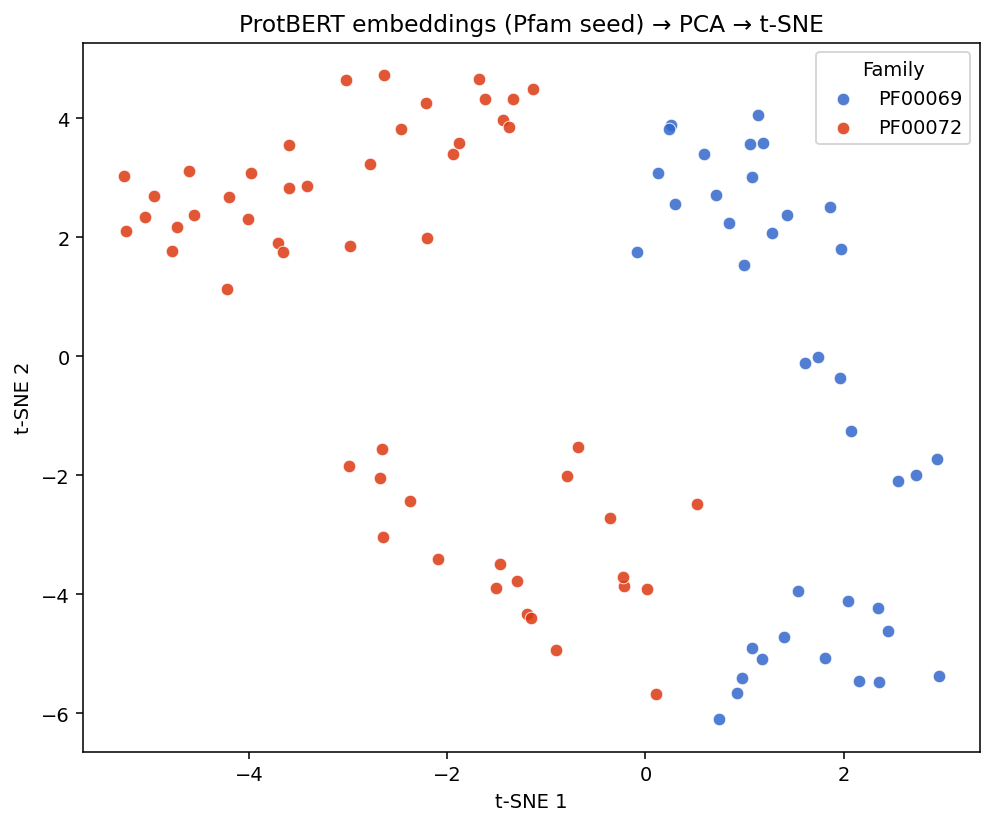

In [ ]:
# ====== Step 6: Plot ======
plt.figure(figsize=(7.2, 6.0), dpi=140)
fam_list = list(dict.fromkeys(labels))  # Preserve original order
palette = ["#3366CC", "#DC3912", "#109618", "#FF9900", "#990099", "#0099C6"]

for idx, fam in enumerate(fam_list):
    m = labels == fam
    plt.scatter(
        X_tsne[m, 0], X_tsne[m, 1],
        s=42, alpha=0.85, label=fam,
        color=palette[idx % len(palette)],
        edgecolors="white", linewidths=0.5,
    )

plt.title("ProtBERT embeddings (Pfam seed) → PCA → t-SNE")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title="Family", loc="best", frameon=True)
plt.tight_layout()
plt.show()

### 10 families (include the 2 selected above, plus 8 randomly sampled families) + Redundancy reduction (~90% identity) + PCA + t-SNE

In [ ]:
random.seed(1)
np.random.seed(1)

# Keep compressed content in bytes for multiple streaming passes
seed_bytes = response.content

# First pass: collect all family accessions (PFxxxxx)
all_fams = []
with gzip.open(io.BytesIO(seed_bytes), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            ac = line.split()[2].split(".")[0]
            all_fams.append(ac)
all_fams = list(dict.fromkeys(all_fams))  # Deduplicate while preserving order

# Randomly sample 8 families different from the existing pfam_ids
pool = [ac for ac in all_fams if ac not in pfam_ids]
extra_fams = random.sample(pool, k=8)
target_fams = pfam_ids + extra_fams
print("Selected families:", target_fams)

Selected families: ['PF00069', 'PF00072', 'PF10097', 'PF19785', 'PF04549', 'PF06168', 'PF07364', 'PF00078', 'PF02478', 'PF01857']


In [ ]:
# ====== Step B: Second pass over Pfam-A.seed; collect alignment blocks for target families and extract sequences ======
def clean_seq(raw):
    """Remove alignment gaps/noise; keep letters only and uppercase."""
    s = str(raw).replace("-", "").replace(".", "").replace("~", "")
    s = "".join([c for c in s if c.isalpha()]).upper()
    return s

records_by_family_all = {fam: [] for fam in target_fams}
current_acc, block_lines = None, []

def process_block_to_rawseqs(block_lines, current_acc):
    if not block_lines or current_acc not in records_by_family_all:
        return
    block_text = "# STOCKHOLM 1.0\n" + "".join(block_lines) + "//\n"
    alignment = AlignIO.read(io.StringIO(block_text), "stockholm")
    for rec in alignment:
        seq = clean_seq(rec.seq)
        if seq:
            records_by_family_all[current_acc].append(seq)

with gzip.open(io.BytesIO(seed_bytes), "rt", encoding="latin-1") as handle:
    for line in handle:
        if line.startswith("#=GF AC"):
            # End previous block
            process_block_to_rawseqs(block_lines, current_acc)
            block_lines = [line]
            current_acc = line.split()[2].split(".")[0]
        elif line.strip() == "//":
            block_lines.append(line)
            process_block_to_rawseqs(block_lines, current_acc)
            block_lines, current_acc = [], None
        else:
            block_lines.append(line)

for fam in target_fams:
    print(f"[RAW] {fam}: {len(records_by_family_all[fam])} sequences in seed")

[RAW] PF00069: 38 sequences in seed
[RAW] PF00072: 52 sequences in seed
[RAW] PF10097: 14 sequences in seed
[RAW] PF19785: 128 sequences in seed
[RAW] PF04549: 18 sequences in seed
[RAW] PF06168: 33 sequences in seed
[RAW] PF07364: 131 sequences in seed
[RAW] PF00078: 69 sequences in seed
[RAW] PF02478: 2 sequences in seed
[RAW] PF01857: 74 sequences in seed


In [ ]:
# ====== Step C: Redundancy reduction (~90% identity threshold) and keep at most 100 per family ======
def seq_identity_quick(a: str, b: str) -> float:
    """Approximate sequence identity (difflib ratio based on matching blocks), fast enough for deduplication."""
    return difflib.SequenceMatcher(None, a, b).ratio()

def dedup_and_sample(seqs, max_keep=100, id_thresh=0.90, seed=42):
    seqs = list(dict.fromkeys(seqs))  # Remove duplicate
    rnd = random.Random(seed)
    rnd.shuffle(seqs)                 # Shuffle to increase diversity
    kept = []
    for s in seqs:
        # Simple length filter within ProtBERT-safe range (BERT limit ~1024, reserve CLS/SEP)
        if not (20 <= len(s) <= 1022):
            continue
        # Compare with kept ones; skip if too similar
        too_close = False
        for t in kept:
            if seq_identity_quick(s, t) >= id_thresh:
                too_close = True
                break
        if not too_close:
            kept.append(s)
        if len(kept) >= max_keep:
            break
    return kept

final_family_seqs = {}
for fam in target_fams:
    final_family_seqs[fam] = dedup_and_sample(records_by_family_all[fam], max_keep=100, id_thresh=0.90, seed=42)
    print(f"[DEDUP] {fam}: kept {len(final_family_seqs[fam])} sequences (<=100, ~90% identity)")

[DEDUP] PF00069: kept 38 sequences (<=100, ~90% identity)
[DEDUP] PF00072: kept 52 sequences (<=100, ~90% identity)
[DEDUP] PF10097: kept 14 sequences (<=100, ~90% identity)
[DEDUP] PF19785: kept 100 sequences (<=100, ~90% identity)
[DEDUP] PF04549: kept 18 sequences (<=100, ~90% identity)
[DEDUP] PF06168: kept 33 sequences (<=100, ~90% identity)
[DEDUP] PF07364: kept 100 sequences (<=100, ~90% identity)
[DEDUP] PF00078: kept 69 sequences (<=100, ~90% identity)
[DEDUP] PF02478: kept 2 sequences (<=100, ~90% identity)
[DEDUP] PF01857: kept 73 sequences (<=100, ~90% identity)


In [ ]:
# ====== Step D: ProtBERT embedding (mean pooling, remove CLS/SEP, L2 normalization) ======
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print("Using device:", device)

name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(name, do_lower_case=False)
model = AutoModel.from_pretrained(name).to(device).eval()
torch.set_grad_enabled(False)

def to_spaced(seq: str) -> str:
    return " ".join(list(seq))

texts, labels = [], []
for fam, seqs in final_family_seqs.items():
    for s in seqs:
        texts.append(to_spaced(s))
        labels.append(fam)
labels = np.array(labels)

def batcher(lst, n=16):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

emb_list = []
bsz = 16 if (device.type == "cuda" or device.type == "mps") else 4

for seq_batch in batcher(texts, bsz):
    enc = tokenizer(seq_batch, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
    enc = {k: v.to(device) for k, v in enc.items()}
    out = model(**enc)  # last_hidden_state: [B, L, D]
    hidden = out.last_hidden_state
    input_ids = enc["input_ids"]
    attn = enc["attention_mask"]

    # Mask out [CLS]/[SEP]
    cls_id, sep_id = tokenizer.cls_token_id, tokenizer.sep_token_id
    special_mask = (input_ids == cls_id) | (input_ids == sep_id)
    valid_mask = attn.bool() & (~special_mask)
    valid_mask = valid_mask.unsqueeze(-1)

    masked = hidden * valid_mask
    lengths = valid_mask.sum(dim=1).clamp(min=1)
    mean_vec = masked.sum(dim=1) / lengths
    mean_vec = torch.nn.functional.normalize(mean_vec, p=2, dim=-1)
    emb_list.append(mean_vec.cpu())

X = torch.cat(emb_list, dim=0).numpy()  # [N, D]
print("Embeddings shape:", X.shape)

Using device: mps


/Users/penglishao/anaconda3/envs/protBERT_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embeddings shape: (499, 1024)


In [ ]:
# ====== Step E: PCA -> t-SNE visualization ======
n_samples, d = X.shape
pca_dim = int(min(50, d, max(2, n_samples - 2)))
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

perplex = max(5, min(30, (n_samples - 1) // 3))
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=perplex, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_6420/3344247134.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(fam_order))


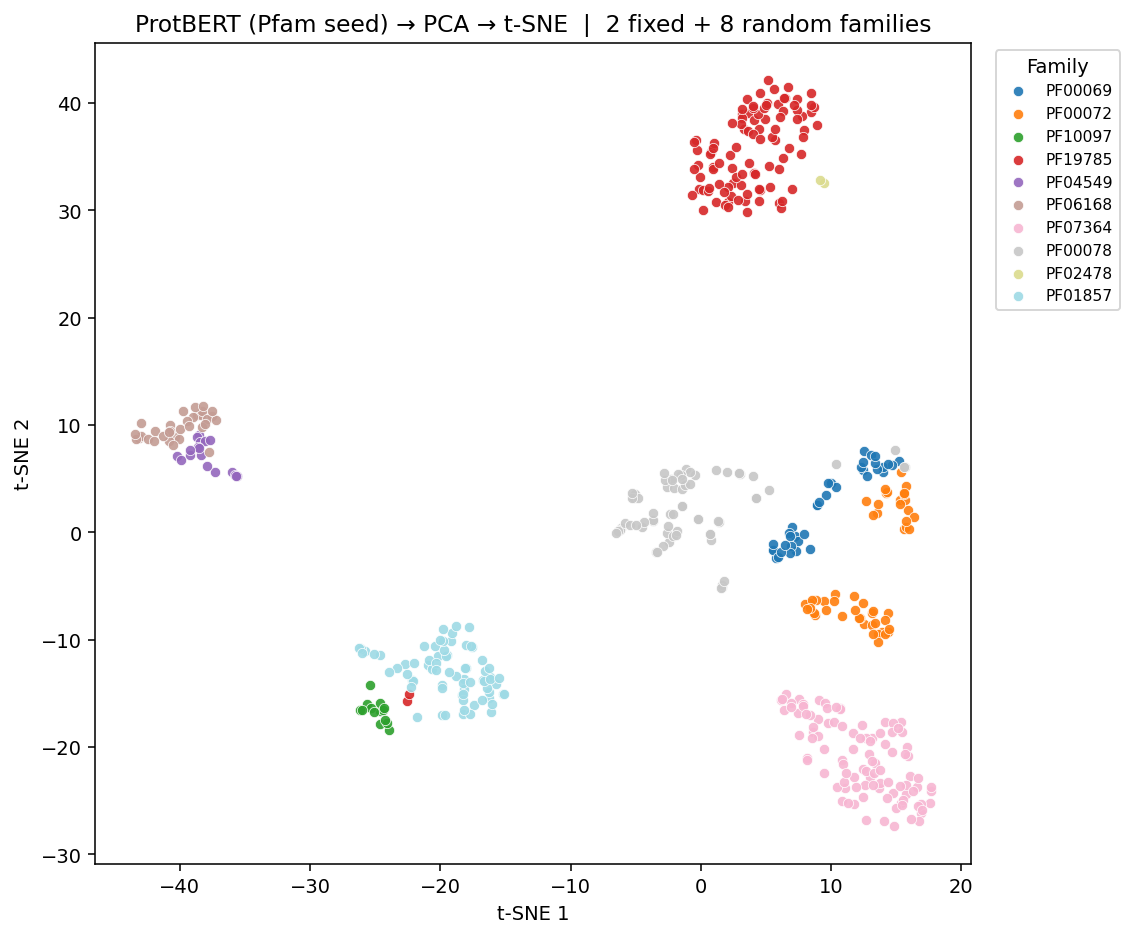

In [ ]:
# ====== Step F: Plot (different colors for different families) ======
plt.figure(figsize=(8.2, 6.8), dpi=140)
fam_order = list(dict.fromkeys(labels))  # Preserve label order
cmap = plt.cm.get_cmap("tab20", len(fam_order))

for idx, fam in enumerate(fam_order):
    m = (labels == fam)
    plt.scatter(
        X_tsne[m, 0], X_tsne[m, 1],
        s=28, alpha=0.9, label=fam,
        color=cmap(idx), edgecolors="white", linewidths=0.4
    )

plt.title("ProtBERT (Pfam seed) → PCA → t-SNE  |  2 fixed + 8 random families")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title="Family", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True, fontsize=8)
plt.tight_layout()
plt.show()